In [1]:
import scanpy as sc
import numpy as np
import os
import sys
import random
from pathlib import Path
import pandas as pd

# PROJECT_DIR = "/home/michal/Github/SRF_Linda_RNA"
PROJECT_DIR = "D:/Github/SRF_Linda_RNA"
WORKING_DIR = f"{PROJECT_DIR}/combine_data"
os.chdir(WORKING_DIR)
sys.path.insert(0, WORKING_DIR)

# Set seeds for all random number generators
random_seed = 0
np.random.seed(random_seed)
random.seed(random_seed)

# REMOVE_DOUBLETS = True
REMOVE_DOUBLETS = False

In [2]:
if REMOVE_DOUBLETS:
    BASE_RESULTS_DIR = os.path.join(WORKING_DIR, "results_from_raw", "doublets_removed")
else:
    BASE_RESULTS_DIR = os.path.join(WORKING_DIR, "results_from_raw")

INPUT_DIR = BASE_RESULTS_DIR
OUTPUT_DIR = INPUT_DIR

adata_path = os.path.join(INPUT_DIR, 'mapmycells.h5ad')
output_file = os.path.join(OUTPUT_DIR, 'annotation_final.h5ad')

os.makedirs(OUTPUT_DIR, exist_ok=True)

LEIDEN_KEY = 'leiden_0.4'
UMAP_KEY = 'X_umap'

In [3]:
# Load merged data from script 1
print(f"\nLoading annotated dataset from {adata_path}")
adata = sc.read_h5ad(adata_path)


Loading annotated dataset from D:/Github/SRF_Linda_RNA/combine_data\results_from_raw\mapmycells.h5ad


In [4]:
# Function to highlight specific cell types
def highlight_cell_types(cell_types_to_highlight, annotation_key, basis="X_umap"):
    """
    Highlight specific cell types on the UMAP plot
    
    Parameters:
    -----------
    cell_types_to_highlight : list
        List of cell type names to highlight
    annotation_key: str
        Column name in adata.obs with cell types
    """
    # Create a boolean mask for the cell types to highlight
    adata.obs['highlight'] = adata.obs[annotation_key].isin(cell_types_to_highlight).astype(str)
    # Plot UMAP with highlighted cell types
    sc.pl.embedding(adata, color='highlight', basis=basis,
               title=f'UMAP with highlighted {annotation_key}: {", ".join(cell_types_to_highlight)}',
               show=True, legend_loc='right margin')

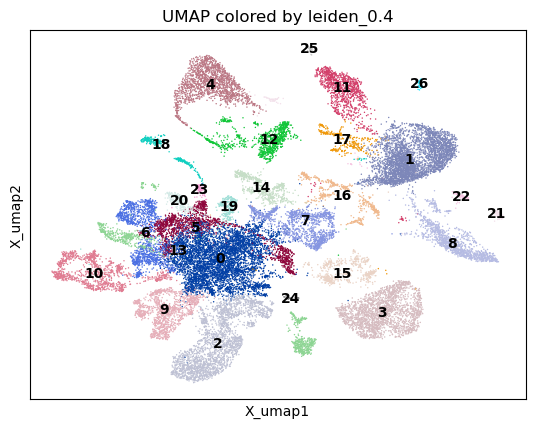

In [5]:
sc.pl.embedding(adata, color=LEIDEN_KEY, basis=UMAP_KEY, title=f'UMAP colored by {LEIDEN_KEY}', show=True, legend_loc='on data')

In [6]:
# Load cell type annotations from CSV files
l1_path = os.path.join(WORKING_DIR, 'models', 'Final_First_Layer.csv')
l2_path = os.path.join(WORKING_DIR, 'models', 'Final_Second_Layer.csv')

df_l1 = pd.read_csv(l1_path, index_col='Barcode')
df_l2 = pd.read_csv(l2_path, index_col='Barcode')

In [7]:
print("df_l2.index[:10]:", df_l2.index[:10])

print("adata.obs.index[:10]:", adata.obs.index[:10])


# The index in adata.obs is formatted like '...-1-0', while the CSV uses '...-1_0'.
# This replaces the last hyphen with an underscore to match the CSV format.
# adata.obs.index = adata.obs.index.map(lambda x: '_'.join(x.rsplit('-', 1)))

# Add cell type annotations to the AnnData object
# The index in the CSV uses '_', while adata.obs.index uses '-'.
# We'll modify the dataframe index to match adata.
df_l1.index = df_l1.index.map(lambda x: '-'.join(x.rsplit('_', 1)))
df_l2.index = df_l2.index.map(lambda x: '-'.join(x.rsplit('_', 1)))

adata.obs['cell_type_L1'] = adata.obs.index.map(df_l1['First Layer Cluster'])
adata.obs['cell_type_L2'] = adata.obs.index.map(df_l2['Second Layer Cluster'])

# Fill NaN values with 'Unknown' if any barcodes were not in the CSVs
adata.obs['cell_type_L1'].fillna('Unknown', inplace=True)
adata.obs['cell_type_L2'].fillna('Unknown', inplace=True)

df_l2.index[:10]: Index(['AAACAGCCAAGCTTTG-1_0', 'AAACATGCAACTAGGG-1_0', 'AAACATGCATTATCCC-1_0',
       'AAACCAACAAACCTTG-1_0', 'AAACCAACAAGGGTTG-1_0', 'AAACCGAAGAGAGCCG-1_0',
       'AAACCGAAGGTGAAAT-1_0', 'AAACCGAAGTTGCGTG-1_0', 'AAACCGCGTAGCTGGT-1_0',
       'AAACCGCGTGAGCAAG-1_0'],
      dtype='object', name='Barcode')
adata.obs.index[:10]: Index(['AAACAGCCAAGCTTTG-1-0', 'AAACAGCCATAAGGAC-1-0', 'AAACATGCAACTAGGG-1-0',
       'AAACATGCAAGTCGCT-1-0', 'AAACATGCATTATCCC-1-0', 'AAACCAACAAACCTTG-1-0',
       'AAACCAACAAGGGTTG-1-0', 'AAACCGAAGAGAGCCG-1-0', 'AAACCGAAGGTGAAAT-1-0',
       'AAACCGAAGTTGCGTG-1-0'],
      dtype='object')


C:\Users\janku\AppData\Local\Temp\ipykernel_41808\850110492.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adata.obs['cell_type_L1'].fillna('Unknown', inplace=True)
C:\Users\janku\AppData\Local\Temp\ipykernel_41808\850110492.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

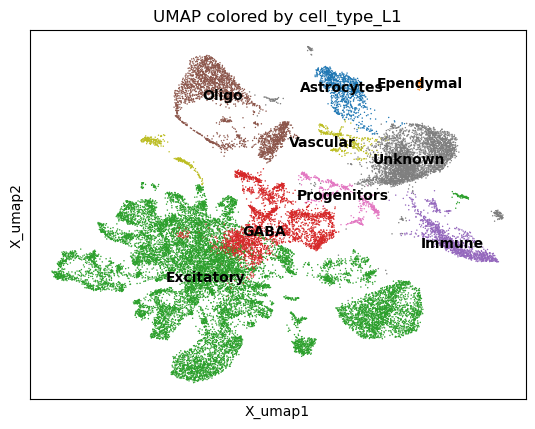

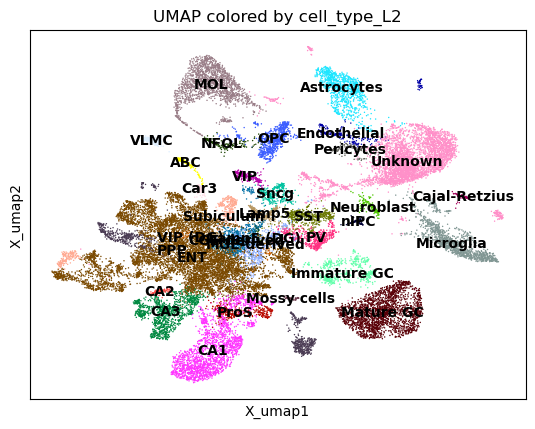

In [8]:
sc.pl.embedding(adata, color="cell_type_L1", basis=UMAP_KEY, title='UMAP colored by cell_type_L1',
           show=True, legend_loc='on data')
sc.pl.embedding(adata, color="cell_type_L2", basis=UMAP_KEY, title='UMAP colored by cell_type_L2',
           show=True, legend_loc='on data')

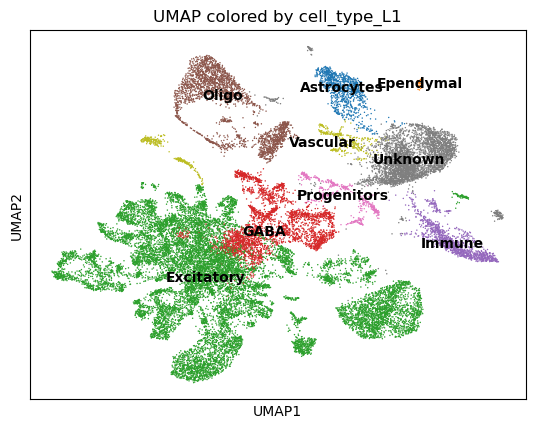

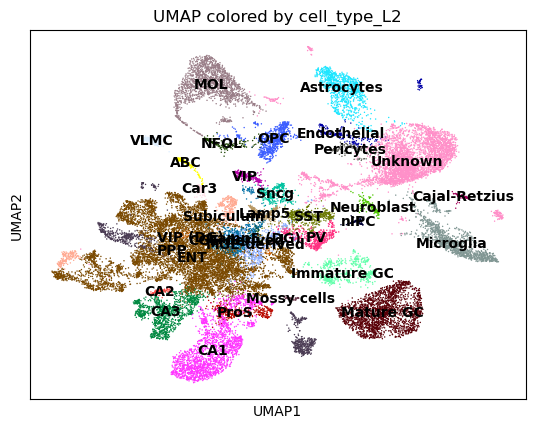

In [9]:
sc.pl.umap(adata, color="cell_type_L1", title='UMAP colored by cell_type_L1',
           show=True, legend_loc='on data')
sc.pl.umap(adata, color="cell_type_L2", title='UMAP colored by cell_type_L2',
           show=True, legend_loc='on data')

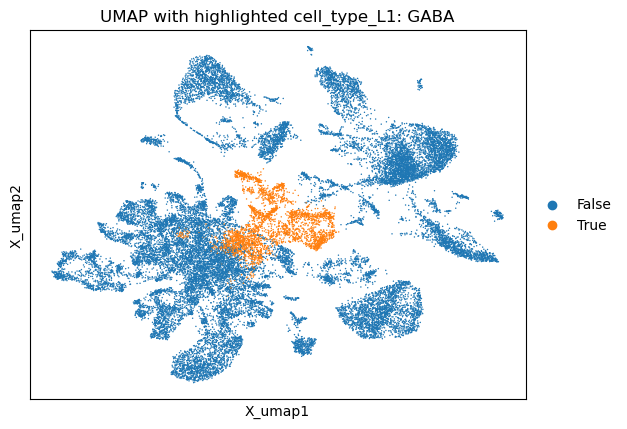

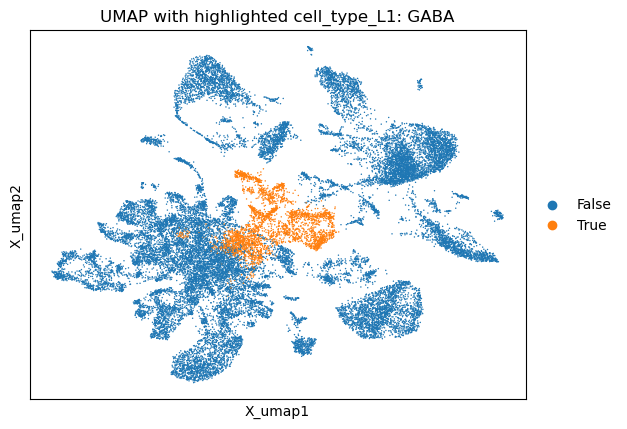

In [10]:
# Example: Highlight specific cell types
cell_types_to_highlight = ["GABA"]
highlight_cell_types(cell_types_to_highlight, "cell_type_L1", basis=UMAP_KEY)
highlight_cell_types(cell_types_to_highlight, "cell_type_L1", basis="X_umap")

In [11]:
# Save the finalized annotated AnnData object
print(f"\nSaving finalized annotated dataset to {output_file}")
adata.write_h5ad(Path(output_file), compression='gzip')


Saving finalized annotated dataset to D:/Github/SRF_Linda_RNA/combine_data\results_from_raw\annotation_final.h5ad
